## ResNet (CIFAR-10)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device: [%s]."%(device))

device: [cuda:0].


### Dataset : CIFAR-10
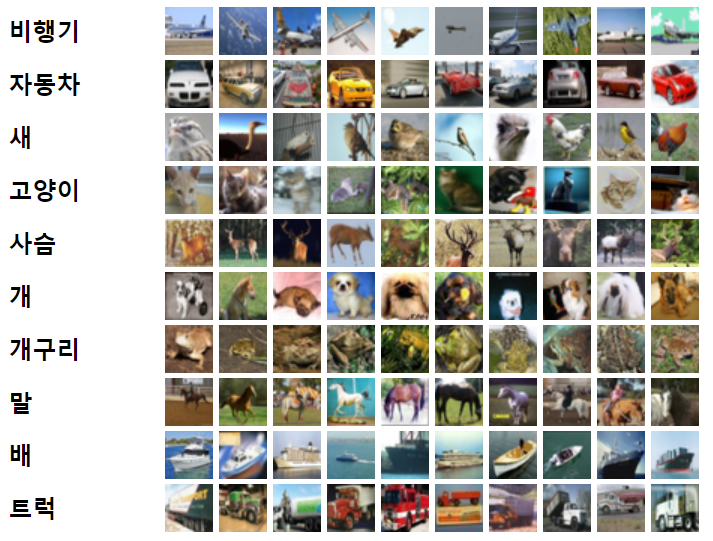
32x32픽셀의 6만대 컬러이미지가 포함되어 있고, 각 이미지는 10개의 클래스로 라벨링 되어있다. 6만개 중, 5만개는 training, 1만개는 test용으로 사용된다. 

In [2]:
import torch
from torchvision import datasets, transforms
CIFAR10_train = datasets.CIFAR10(root='./data/', train=True,
                                transform = transforms.ToTensor(),
                                download=True)
CIFAR10_test = datasets.CIFAR10(root='./data/', train=False,
                                transform = transforms.ToTensor(),
                                download=True)
print("CIFAR10_train:\n", CIFAR10_train, "\n")
print("CIFAR10_test:\n", CIFAR10_test, "\n")
print("Done.")

Files already downloaded and verified
Files already downloaded and verified
CIFAR10_train:
 Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

CIFAR10_test:
 Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


### Data Iterator

In [3]:
BATCH_SIZE = 64
train_iter = torch.utils.data.DataLoader(CIFAR10_train, batch_size = 
                                        BATCH_SIZE, shuffle=True,
                                        num_workers=1)
test_iter = torch.utils.data.DataLoader(CIFAR10_test, batch_size =
                                       BATCH_SIZE, shuffle=False,
                                       num_workers=1)
print("Done.")

Done.


### Define Model

* Input image : 32x32
* layer 1 : 3x3 conv
* (layer 2)x3 : 3x3conv,16 / output:32x32
* (layer 3)x3 : 3x3conv,32 / output:16x16
* (layer 4)x3 : 3x3conv,64 / output:8x8
* fc 10-d : avgpool, softmax / output:1x1

In [4]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels,
                stride=1,downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x) 
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample: #layer set마다 32, 16, 8로 줄어든다.
            identity = self.downsample(x)
        
        out = out + identity
        out = self.relu(out)
        
        return out
    

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        
        self.in_channels = 16
        # 1st layer
        self.conv = conv3x3(3,16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        # Residual Block layers
        self.layer1 = self.make_layer(block, 16, layers[0]) # x3
        self.layer2 = self.make_layer(block, 32, layers[1], 2) # x3
        self.layer3 = self.make_layer(block, 64, layers[2], 2) # x3
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        # residual block set이 끝날 때 downsampling이 있다. 
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
            
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, 
                                downsample))
        self.in_channels = out_channels
            
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
        
    def forward(self,x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

* model을 다음과 같이 정의했는데, 에러가 발생했다. 

*TypeError: conv3x3() takes from 2 to 3 positional arguments but 4 were given*

* This error is often caused by the fact that the self is omitted as a parameter in the method of the class.

residual block set이 끝날 때 downsampling이 있는데, 이때 conv3x3 함수에서 parameter로 2-3개의 parameter를 받는다. 그런데 여기 parameter로 downsample을 추가해놔서 발생한 오류였다.

In [7]:
model = ResNet(ResidualBlock, [2,2,2]).to(device)

In [8]:
loss = nn.CrossEntropyLoss()
optm = optim.Adam(model.parameters(), lr=1e-3)
print('Done.')

Done.


In [9]:
print(model)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

### Evaluation

In [10]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0, 0
        model.eval()
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1, 3, 32, 32).to(device))
            _, y_pred = torch.max(model_pred.data, 1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train()
    return val_accr
print("Done.")

Done.


### Check Parameters
#### weight, bias of each layers
np.set_printoptions(precision=None, threshold=None, ...): precision : output 소수점 아래 자리를 고정하기 위해 사용함. 
#### Parameter를 확인하는 방법 2가지
1. torch.nn.Module.parameters() : layer 이름을 제외한 parameter 값에 대한 iterator를 리턴함  
2. torch.nn.Module.named_parameters() : (parameter name, parameter)의 튜플 iterator 리턴함. 

In [11]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(model.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy()
        n_param += len(param_numpy.reshape(-1))
        print("[%d] name: [%s] shape:[%s]."%(p_idx, param_name, param_numpy.shape))
        print("     val:%s"%(param_numpy.reshape(-1)[:5]))
    print("Total number of parameters:[%s]."%(format(n_param, ',d')))

[0] name: [conv.weight] shape:[(16, 3, 3, 3)].
     val:[ 0.035 -0.187 -0.187  0.133 -0.178]
Total number of parameters:[432].
[1] name: [bn.weight] shape:[(16,)].
     val:[1. 1. 1. 1. 1.]
Total number of parameters:[448].
[2] name: [bn.bias] shape:[(16,)].
     val:[0. 0. 0. 0. 0.]
Total number of parameters:[464].
[3] name: [layer1.0.conv1.weight] shape:[(16, 16, 3, 3)].
     val:[ 0.032 -0.058 -0.064 -0.048 -0.06 ]
Total number of parameters:[2,768].
[4] name: [layer1.0.bn1.weight] shape:[(16,)].
     val:[1. 1. 1. 1. 1.]
Total number of parameters:[2,784].
[5] name: [layer1.0.bn1.bias] shape:[(16,)].
     val:[0. 0. 0. 0. 0.]
Total number of parameters:[2,800].
[6] name: [layer1.0.conv2.weight] shape:[(16, 16, 3, 3)].
     val:[-0.078  0.014  0.056 -0.02  -0.067]
Total number of parameters:[5,104].
[7] name: [layer1.0.bn2.weight] shape:[(16,)].
     val:[1. 1. 1. 1. 1.]
Total number of parameters:[5,120].
[8] name: [layer1.0.bn2.bias] shape:[(16,)].
     val:[0. 0. 0. 0. 0.]
Total

In [12]:
train_accr = func_eval(model, train_iter, device)
test_accr = func_eval(model, test_iter, device)
print("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr, test_accr))

train_accr:[0.139] test_accr:[0.140].


### Train

In [13]:
print ("Start training.")
model.train() # to train mode 
EPOCHS,print_every = 10,2
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = model.forward(batch_in.view(-1,3,32,32).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()     # reset gradient 
        loss_out.backward()     # backpropagate
        optm.step()     # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(model,train_iter,device)
        test_accr = func_eval(model,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[1.299] train_accr:[0.592] test_accr:[0.580].
epoch:[2] loss:[0.738] train_accr:[0.766] test_accr:[0.742].
epoch:[4] loss:[0.561] train_accr:[0.750] test_accr:[0.717].
epoch:[6] loss:[0.445] train_accr:[0.851] test_accr:[0.783].
epoch:[8] loss:[0.361] train_accr:[0.894] test_accr:[0.805].
epoch:[9] loss:[0.322] train_accr:[0.892] test_accr:[0.795].
Done


### Save model

In [27]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_iter:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    

Accuracy of the model on the test images: 79.46 %


### Test

*TypeError: only integer scalar arrays can be converted to a scalar index*

In [31]:
n_sample = 25
%matplotlib inline
%config InlineBackend.figure_format='retina'
sample_indices = np.random.choice(len(CIFAR10_test.targets), n_sample, 
                                  replace=False)
for idx in sample_indices:
    y_pred = model.forward(CIFAR10_test.data[idx].view(-1,3,32,32).type(torch.float).to(device))
    y_pred = y_pred.argmax(axis=1)
    plt.subplot(5,5, idx+1)
    plt.imshow(CIFAR10_test.data[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label: %d"%(y_pred[idx], CIFAR10_test.targets[idx]))
plt.show()
print("Done")

TypeError: view() takes from 0 to 2 positional arguments but 4 were given

In [23]:
PATH = './cifar10.resnet.pth'
torch.save(model.state_dict(), PATH)